## Libraries

In [124]:
# basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# model
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from alepython import ale_plot
from ale_utils import first_order_aleplot_quant, second_order_aleplot_quant
from alepython.ale import _first_order_ale_quant
from alepython.ale import _second_order_ale_quant,_second_order_quant_plot,_get_centres
from PyALE import ale

## Data Manipulation

In [53]:
mode_allcat = pd.read_csv("mode_allcat.csv")
mode_ordinal = pd.read_csv("mode_ordinal.csv")
nan_allcat = pd.read_csv("nan_allcat.csv")

In [68]:
# change column name for xgboost
mode_allcat = mode_allcat.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(less_than_20)'})
mode_ordinal = mode_ordinal.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(less_than_20)'})
nan_allcat = nan_allcat.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(less_than_20)'})

## Modeling

### Decision Tree

Data 1 best param: DecisionTreeClassifier(max_depth=10, min_samples_leaf=12, min_samples_split=80,
                       random_state=7, splitter='random')
Model AUC (with data 1) = 0.7467476751442097


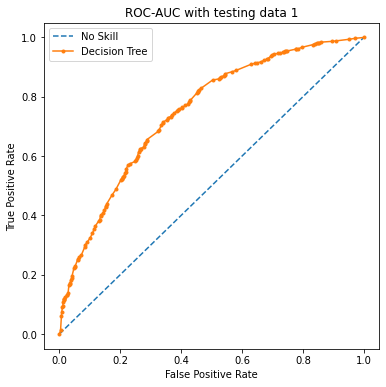

Data 2 best param: DecisionTreeClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=80,
                       random_state=7, splitter='random')
Model AUC (with data 2) = 0.7479142251241699


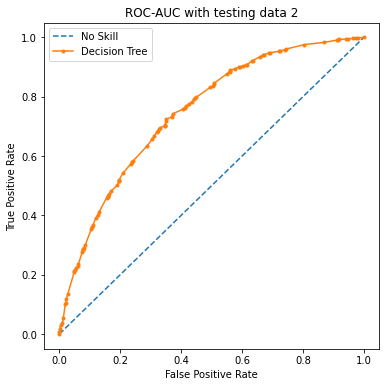

Data 3 best param: DecisionTreeClassifier(max_depth=10, min_samples_leaf=12, min_samples_split=80,
                       random_state=7, splitter='random')
Model AUC (with data 3) = 0.7458534998401899


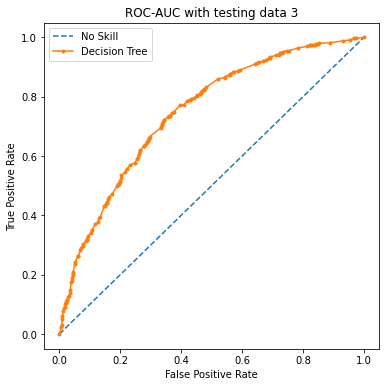

In [55]:
# param to search
dtc = {
    "criterion":["gini","entropy","log_loss"],
    "splitter":["best","random"],
    "max_depth":[12,10,8,7],
    "min_samples_split":[10,20,40,80],
    "min_samples_leaf":[7,10,12,15],
    "max_leaf_nodes":[None],
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    tree = GridSearchCV(DecisionTreeClassifier(random_state=7), dtc, n_jobs=1, scoring='roc_auc', cv=4)
    
    tree.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {tree.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = tree.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()